# Project 15 : Good Seed Supermarket

## Introduction

The supermarket chain "Good Seed" wants to comply with the law by ensuring that it does not sell age-restricted products to underage customers.

### Goal

This project aims to develop a model that can verify the age of customers with the help of the *computer vision* method with an MAE score on the *test set* of less than 8.

### Step

To develop the model, we will use the images with ages stored in the `/datasets/faces/` folder. Model development will consist of the following main stages:
1. Loading the dataset and checking the quality of the dataset.
2. Performing EDA.
3. Modeling and defining functions for training.
4. Training the model on the GPU platform.
5. Analyzing the output.

### Overview

**1. Introduction**
- Objective
- Stages
- Overview

**2. Data Preparation**
- Initialization
- Load Data

**3. EDA**
- Age Distribution
- Sample Photos with Age
- Findings

**4. Modeling**

**5. Script to run on GPU platform**
- Output

**6. Conclusion**

## Data Preparation

### Initialization 

Prepare all necessary libraries.

In [6]:
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

### Loading Dataset

The *datasets* you need are stored in the `/datasets/faces/` folder. In that folder, you can find: - The `final_file` folder with 7.6k photos 
- The *file* `labels.csv` that contains the labels, has two columns: `file_name` and `real_age`. 

Since the number of image *files* is quite large, you are advised not to read them all at once, as this will only consume computing resources. We recommend that you create a generator with ImageDataGenerator. This method was described earlier in Chapter 3, Lesson 7. 

The label *file* can be loaded as a normal CSV *file*.

In [7]:
# memuat dataset dan menyimpannya dalam variabel labels
labels = pd.read_csv('/datasets/faces/labels.csv')

In [8]:
# menampilkan sampel dataset
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [9]:
# menampilkan informasi umum dataset
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [10]:
# menampilkan statistika deskriptif dataset
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [11]:
# menampilkan nilai yang hilang
labels.isna().sum()

file_name    0
real_age     0
dtype: int64

***
**Findiings**
Berdasarkan sajian data diatas, diperoleh informasi :
- Dataset terdiri atas 7591 baris dan 2 kolom.
- Tidak ada nilai yang hilang pada dataset.
- Diketahui bahwa usia rata-rata customer adalah 31 tahun, dengan usia termuda 1 tahun dan tertua adalah 100 tahun.

## EDA

Before conducting data exploration, image extraction from the `/datasets/faces/final_files/` folder is first performed.

In [15]:
# ekstraksi gambar dari folder final_files
train_datagen = ImageDataGenerator(rescale=1./255)

train_gen_flow = train_datagen.flow_from_dataframe(
    dataframe=labels,
    directory='/datasets/faces/final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    seed=12345
)

Found 7591 validated image filenames.


### Age Distribution

The first step was to do the age grouping and look at the distribution.

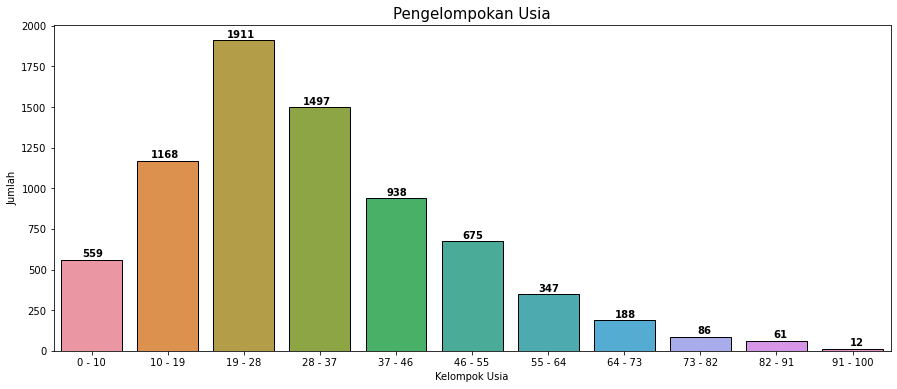

In [17]:
# menampilkan grafik kelompok usia
bins = np.arange(labels['real_age'].min(), labels['real_age'].max()+6, 9)
bin_label = ['0 - 10', '10 - 19', '19 - 28', '28 - 37', '37 - 46', '46 - 55', '55 - 64',
             '64 - 73', '73 - 82', '82 - 91', '91 - 100']
plot_bar = labels.groupby(pd.cut(labels['real_age'], bins=bins)).agg({'real_age': 'count'}).rename(columns={'real_age': 'Jumlah'})
plot_bar['Kelompok Usia'] = bin_label
fig, ax = plt.subplots(figsize=(15,6))
grap = sns.barplot(x='Kelompok Usia', y= 'Jumlah', data = plot_bar, edgecolor='black')
grap.set_title('Pengelompokan Usia', fontdict={'size':15})
grap.set_xticklabels(bin_label);
for i, v in enumerate(plot_bar.iloc[:,0].values):
    grap.text(i + 0.15, v + 7, str(v),
              color='black', fontweight='bold',
              fontdict={'horizontalalignment':'right', 'verticalalignment':'bottom', 'size':10})

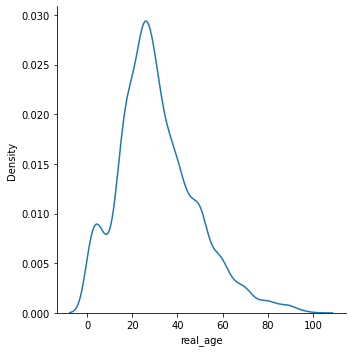

In [18]:
# menampilkan distribusi data usia
sns.displot(labels, x="real_age", kind="kde")

### Sample Photos with Age

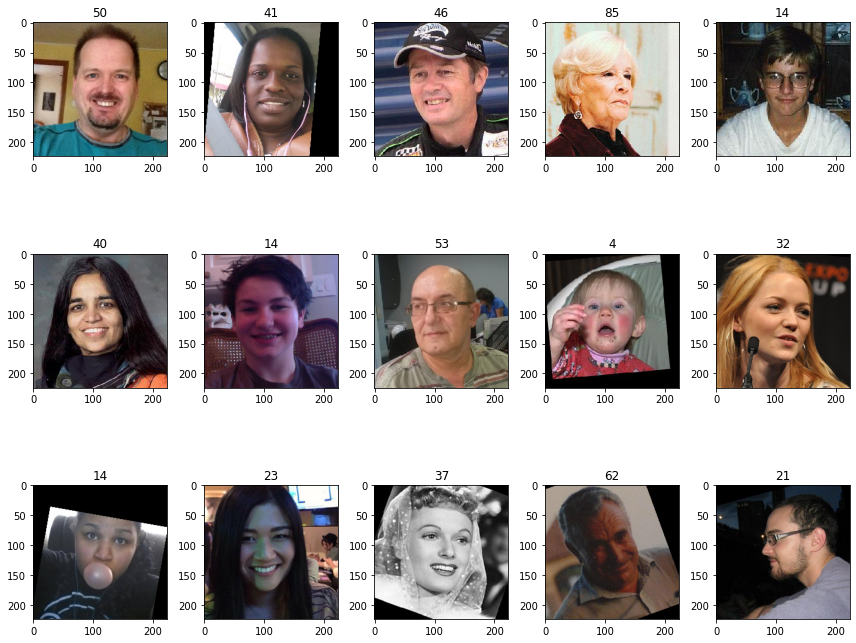

In [19]:
# menampilkan contoh gambar beserta usia
features, target = next(train_gen_flow)
fig = plt.figure(figsize=(12, 12))
for i in range(15):
    fig.add_subplot(3, 5, i+1)
    plt.imshow(features[i])
    plt.title(target[i])
    plt.tight_layout()

### FIndings

Based on the above age distribution graph, it can be seen that the dataset generally contains ages around `20 - 40 years`, where the age group `19 - 28 years` is the largest at `1911`. In the bar chart, there is a high peak in the `0-10 years` age group. This data is needed to anticipate the possibility of parents bringing their children when visiting the store.

## Modeling 

Define the functions required to train your model on a GPU platform and create a single script that contains all these functions along with an initialization section.

To make this task easier, you can define them in this *notebook* and run the ready-made code in the next section to build the script automatically.
The definitions below will also be checked by the *project reviewer* so that they can understand how you built the model.

In [20]:
# membuat fungsi loading dataset training
def load_train(path):
    
    """
    Kode ini memuat bagian training set dari file path
    """
     # loading datset
    labels = pd.read_csv('/datasets/faces/labels.csv')
    
    # data generator
    datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255,
        horizontal_flip=True,
        vertical_flip=True,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rotation_range=90)
    
    # ekstraksi gambar dari folder
    train_datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels, directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345
    )
    
    return train_datagen_flow

In [21]:
# membuat fungsi loading dataset test
def load_test(path):
    
    """
    Kode ini memuat bagian validation set/test set dari file path
    """
    # loading datset
    labels = pd.read_csv('/datasets/faces/labels.csv')
    
    # data generator
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    
    # ekstraksi gambar dari folder
    test_datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)
    
    return test_datagen_flow

In [22]:
# membuat fungsi modeling
def create_model(input_shape):
    
    """
    Kode ini mendefinisikan model
    """
    
    backbone = ResNet50(
        input_shape=input_shape,
        weights='imagenet',
        include_top=False)
    model = Sequential()
    
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=168, activation='relu'))
    model.add(Dense(units=84, activation='relu'))
    model.add(Dense(units=6, activation='relu'))
    
    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer,loss='mse', metrics=['mae'])
    
    return model

In [23]:
# membuat fungsi pelatihan model
def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    """
    Melatih model dengan parameter yang diberikan
    """
    
    model.fit(
        train_data,
        validation_data=test_data,
        batch_size=batch_size,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2
    ) 
    return model

## Set up Scripts to run on GPU platforms

Once you have defined the necessary functions, you can create a script for the GPU platform, download it via the "File|Open..." menu, and upload it later to run on the GPU platform. "

In [ ]:
# siapkan skrip untuk menjalankan platform GPU

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### Output

Put the *output* of the GPU platform as a *Markdown* cell here.

**Found 5694 validated image filenames.**

**Found 1897 validated image filenames.**

`Downloading data from https://github.com/keras-team/keras-applications/releases/download/resnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
<class 'tensorflow.python.keras.engine.sequential.Sequential'>`

**Train for 178 steps, validate for 60 steps**

**Epoch 1/10**
`178/178 - 111s - loss: 357.5221 - mae: 14.0170 - val_loss: 567.7134 - val_mae: 18.7804`

**Epoch 2/10**
`178/178 - 103s - loss: 140.3052 - mae: 9.0316 - val_loss: 493.8319 - val_mae: 17.1195`

**Epoch 3/10**
`178/178 - 102s - loss: 123.2001 - mae: 8.5071 - val_loss: 430.7654 - val_mae: 15.6857`

**Epoch 4/10**
`178/178 - 102s - loss: 111.6260 - mae: 8.0624 - val_loss: 149.0971 - val_mae: 9.1615`

**Epoch 5/10**
`178/178 - 103s - loss: 101.3590 - mae: 7.6335 - val_loss: 172.9916 - val_mae: 9.7837`

**Epoch 6/10**
`178/178 - 102s - loss: 94.3314 - mae: 7.4046 - val_loss: 110.4739 - val_mae: 7.9724`

**Epoch 7/10**
`178/178 - 104s - loss: 88.6717 - mae: 7.1885 - val_loss: 100.8116 - val_mae: 7.6625`

**Epoch 8/10**
`178/178 - 104s - loss: 83.1234 - mae: 6.9745 - val_loss: 165.7365 - val_mae: 9.5604`

**Epoch 9/10**
`178/178 - 103s - loss: 77.6746 - mae: 6.7423 - val_loss: 106.1114 - val_mae: 7.5862`

**Epoch 10/10**
`178/178 - 104s - loss: 73.0743 - mae: 6.5289 - val_loss: 94.4559 - val_mae: 7.3656`

**60/60 - 10s - loss: 94.4559 - mae: 7.3656**

**Test MAE: 7.3656**

## Conclusion

- The received dataset is an image and age data set containing 7591 rows and 2 columns, along with a collection of images containing 7591 photos of various ages from 1 year to 100 years old. After checking, there are no missing values in this dataset.

- Based on the data exploration analysis, it is found that the dataset generally contains ages around `20 - 40 years`, where the age group `19 - 28 years` is the largest at `1911`. In the bar chart, there is a high peak in the age group `0-10 years`, this data is needed to anticipate the possibility of parents bringing their children when visiting the store.
- To build the model, the steps taken include:
1. Perform augmentation on the training dataset, including: vertical and horizontal reflection, vertical and horizontal shift up to 20% of the actual size, and rotation up to 90 degrees.
2. The developed model uses the **ResNet50** architecture from TensorFlow, with the addition of the `GlobalAveragePooling2D` class and three fully connected layers with `ReLu` activation. The optimizer chosen is `ADAM` with a `learning_rate of 0.0001`.  The loss_function chosen is `MSE` as this project is a regression task.

- After training the model on the GPU platform with `10 epochs`, the `MAE` metric score on the train dataset is **6.5289** and on the test dataset is **7.3656**. These results show that the quality of the model is quite good where there is no overfitting in the model and the model is quite capable of accurately predicting age. It can be concluded that the developed computer vision method can be used by Good Seed to help verify the age of customers to comply with age-restricted product usage regulations.

- Other tasks that allow the use of computer vision methods include the manufacturing field, where this method can be used as a quality control tool and for remote monitoring of the quality of the physical appearance of the product. This method can also be applied in the healthcare field to help monitor the progress of patient recovery related to the patient's physical condition.
